In [1]:
import gdown
import os
import random
import re

import pandas as pd

from tqdm.auto import tqdm
tqdm.pandas()
from rdkit import Chem

# to display molecules
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True


# disable RDKit warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') 

In [2]:
# check if you have a notebook with a GPU
import torch
torch.cuda.is_available()
# If False, Go to Menu > Runtime > Change runtime. Hardware accelerator -> GPU

True

In [3]:
SMI_REGEX_PATTERN =  r"(\%\([0-9]{3}\)|\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\||\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"

def smiles_tokenizer(smiles):
    smiles_regex = re.compile(SMI_REGEX_PATTERN)
    tokens = [token for token in smiles_regex.findall(smiles)]
    return ' '.join(tokens)

In [4]:
def download_data():
    # links from https://github.com/coleygroup/Graph2SMILES/blob/main/scripts/download_raw_data.py
    USPTO_480k_links= [
            ("https://drive.google.com/uc?id=1RysNBvB2rsMP0Ap9XXi02XiiZkEXCrA8", "src-train.txt"),
            ("https://drive.google.com/uc?id=1CxxcVqtmOmHE2nhmqPFA6bilavzpcIlb", "tgt-train.txt"),
            ("https://drive.google.com/uc?id=1FFN1nz2yB4VwrpWaBuiBDzFzdX3ONBsy", "src-val.txt"),
            ("https://drive.google.com/uc?id=1pYCjWkYvgp1ZQ78EKQBArOvt_2P1KnmI", "tgt-val.txt"),
            ("https://drive.google.com/uc?id=10t6pHj9yR8Tp3kDvG0KMHl7Bt_TUbQ8W", "src-test.txt"),
            ("https://drive.google.com/uc?id=1FeGuiGuz0chVBRgePMu0pGJA4FVReA-b", "tgt-test.txt")
        ]
    data_path = 'USPTO_480k'
    os.makedirs(data_path, exist_ok=True)
    for url, name in USPTO_480k_links:
        target_path = os.path.join(data_path, name)
        if not os.path.exists(target_path):
            gdown.download(url, target_path, quiet=False)
        else:
            print(f"{target_path} already exists")

def canonicalize_smiles(smiles, verbose=True): # will raise an Exception if invalid SMILES
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return Chem.MolToSmiles(mol)
    else:
        if verbose:
            print(f'{smiles} is invalid.')
        return ''

In [5]:
download_data()

USPTO_480k/src-train.txt already exists
USPTO_480k/tgt-train.txt already exists
USPTO_480k/src-val.txt already exists
USPTO_480k/tgt-val.txt already exists
USPTO_480k/src-test.txt already exists
USPTO_480k/tgt-test.txt already exists


# Load the data

In [6]:
data_path = 'USPTO_480k'
file_names = ['train_df.csv', 'val_df.csv', 'test_df.csv']

# Check if all files exist in the folder
if all([os.path.exists(os.path.join(data_path, file_name)) for file_name in file_names]):
    print("All files exist in the folder.")
else:
    line_count = !cat USPTO_480k/src-train.txt | wc -l
    total = int(line_count[0])
    with open('USPTO_480k/src-train.txt', 'r') as f:
        precursors_train = [canonicalize_smiles(line.strip().replace(' ', '')) for line in tqdm(f, total=total)]
    with open('USPTO_480k/tgt-train.txt', 'r') as f:
        products_train = [canonicalize_smiles(line.strip().replace(' ', '')) for line in tqdm(f, total=total)]

    line_count = !cat USPTO_480k/src-val.txt | wc -l
    total = int(line_count[0])
    with open('USPTO_480k/src-val.txt', 'r') as f:
        precursors_val = [canonicalize_smiles(line.strip().replace(' ', '')) for line in tqdm(f, total=total)]
    with open('USPTO_480k/tgt-val.txt', 'r') as f:
        products_val = [canonicalize_smiles(line.strip().replace(' ', '')) for line in tqdm(f, total=total)]

    line_count = !cat USPTO_480k/src-test.txt | wc -l
    total = int(line_count[0])
    with open('USPTO_480k/src-test.txt', 'r') as f:
        precursors_test = [canonicalize_smiles(line.strip().replace(' ', '')) for line in tqdm(f, total=total)]
    with open('USPTO_480k/tgt-test.txt', 'r') as f:
        products_test = [canonicalize_smiles(line.strip().replace(' ', '')) for line in tqdm(f, total=total)]

    train_df = pd.DataFrame({'precursors': precursors_train, 'products': products_train})
    print(f"The training set contains {train_df.shape[0]} reactions.")

    val_df = pd.DataFrame({'precursors': precursors_val, 'products': products_val})
    print(f"The validation set contains {val_df.shape[0]} reactions.")

    test_df = pd.DataFrame({'precursors': precursors_test, 'products': products_test})
    print(f"The test set contains {test_df.shape[0]} reactions.")

    train_df.to_csv('USPTO_480k/train_df.csv')
    val_df.to_csv('USPTO_480k/val_df.csv')
    test_df.to_csv('USPTO_480k/test_df.csv')

All files exist in the folder.


# Load saved datasets

In [7]:
train_df = pd.read_csv('USPTO_480k/train_df.csv',index_col=0)
val_df = pd.read_csv('USPTO_480k/val_df.csv',index_col=0)
test_df = pd.read_csv('USPTO_480k/test_df.csv',index_col=0)

# Sanity chech - Canoncalization

There is no standard for the canonicalization of SMILES. We might find SMILES that differ... A potential reason for this is that the canonicalization has changed with a newer RDKit version. So, always state the RDKit version that you are working with.

In [14]:
line_count = !cat USPTO_480k/src-val.txt | wc -l
total = int(line_count[0])+1
with open('USPTO_480k/src-val.txt', 'r') as f:
    can_precursors_val = [canonicalize_smiles(line.strip().replace(' ', '')) for line in tqdm(f, total=total)]

for smiles, can_smiles in zip(precursors_val, can_precursors_val):
    try:
        assert smiles == can_smiles
    except AssertionError:
        print(smiles)
        print(can_smiles)
    break

# Tokenization

To be able to train a language model, we need to split the strings into tokens.

We take the regex pattern introduced in the Molecular Transformer.

In [15]:
print('Tokenizing training set')
train_df['tokenized_precursors'] = train_df.precursors.progress_apply(lambda smi: smiles_tokenizer(smi))
train_df['tokenized_products'] = train_df.products.progress_apply(lambda smi: smiles_tokenizer(smi))
print('Tokenizing validation set')
val_df['tokenized_precursors'] = val_df.precursors.progress_apply(lambda smi: smiles_tokenizer(smi))
val_df['tokenized_products'] = val_df.products.progress_apply(lambda smi: smiles_tokenizer(smi))
print('Tokenizing test set')
test_df['tokenized_precursors'] = test_df.precursors.progress_apply(lambda smi: smiles_tokenizer(smi))
test_df['tokenized_products'] = test_df.products.progress_apply(lambda smi: smiles_tokenizer(smi))

# Save the preprocessed data set

Don't forget to shuffle the training set before saving it. At least earlier versions of OpenNMT-py would not shuffle it during preprocessing.

In [12]:
shuffled_train_df = train_df.sample(frac=1., random_state=42)

data_path = 'USPTO_480k_preprocessed'

os.makedirs(data_path, exist_ok=True)
with open(os.path.join(data_path, 'precursors-train.txt'), 'w') as f:
    f.write('\n'.join(shuffled_train_df.tokenized_precursors.values))
with open(os.path.join(data_path, 'products-train.txt'), 'w') as f:
    f.write('\n'.join(shuffled_train_df.tokenized_products.values))

with open(os.path.join(data_path, 'precursors-val.txt'), 'w') as f:
    f.write('\n'.join(val_df.tokenized_precursors.values))
with open(os.path.join(data_path, 'products-val.txt'), 'w') as f:
    f.write('\n'.join(val_df.tokenized_products.values))
    
with open(os.path.join(data_path, 'precursors-test.txt'), 'w') as f:
    f.write('\n'.join(test_df.tokenized_precursors.values))
with open(os.path.join(data_path, 'products-test.txt'), 'w') as f:
    f.write('\n'.join(test_df.tokenized_products.values))

train_df = shuffled_train_df.copy()

train_df.to_csv(f'{data_path}/train_df.csv')
val_df.to_csv(f'{data_path}/val_df.csv')
test_df.to_csv(f'{data_path}/test_df.csv')

# Load the preprocessed data sets

In [8]:
data_path = 'USPTO_480k_preprocessed'

train_df = pd.read_csv(f'{data_path}/train_df.csv', index_col=0)
val_df = pd.read_csv(f'{data_path}/val_df.csv', index_col=0)
test_df = pd.read_csv(f'{data_path}/test_df.csv', index_col=0)

# Downlaod the trained model

The training can take more than 24 hours on a single GPU. Hence, we will download the trained model.

In [9]:
trained_model_url = 'https://drive.google.com/uc?id=1ywJCJHunoPTB5wr6KdZ8aLv7tMFMBHNy'
model_folder = 'models'
model_name = 'USPTO480k_model_step_400000.pt'

os.makedirs(model_folder, exist_ok=True)
target_path = os.path.join(model_folder, model_name)
if not os.path.exists(target_path):
    gdown.download(trained_model_url, target_path, quiet=False)
else:
    print(f"{target_path} already exists")

models/USPTO480k_model_step_400000.pt already exists


## Model evaluation script

In [17]:
# !onmt_translate -model models/USPTO480k_model_step_400000.pt -gpu -1 \
#     --src USPTO_480k_preprocessed/precursors-val.txt \
#     --tgt USPTO_480k_preprocessed/products-val.txt \
#     --output models/USPTO480k_model_step_400000_val_predictions.txt \
#     --n_best 5 --beam_size 10 --max_length 300 --batch_size 64

# Exercise: Test the limits of the Molecular Transformer!


[2023-06-28 16:13:47,261 INFO] Translating shard 0.
[2023-06-28 16:13:48,062 INFO] PRED AVG SCORE: -0.0000, PRED PPL: 1.0000


The SMILES of the predicted product is: Cn1c2c(Cl)cccc2c2cc(C(=O)O)sc21


Visualization of the reaction:

Precursors:


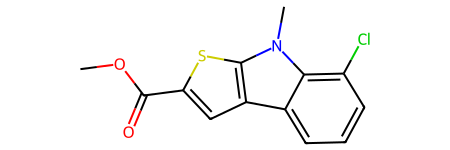

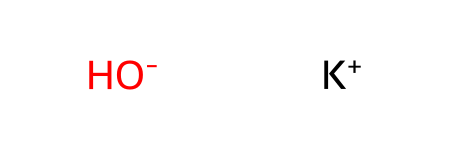

Product:


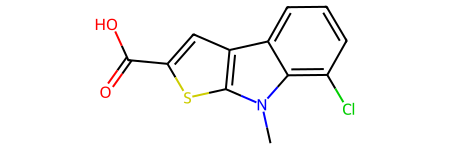

In [76]:
# It's an example
import pubchempy as pcp
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import display


def predict_reaction(precursors):
    """ predict product of one reaction from its precursors SMILES list
    """
    smi_pres = '.'.join(precursors)
    smi_pres = smiles_tokenizer(smi_pres)

    with open('precursors-try.txt', 'w') as f:
        f.write(f'{smi_pres}\n')

    os.system("rm preds.txt")
    os.system("onmt_translate -model models/USPTO480k_model_step_400000.pt -gpu 0 \
               --src precursors-try.txt --output preds.txt \
               --n_best 1 --beam_size 5 --max_length 300 --batch_size 64")

    with open('preds.txt', 'r') as f:
        pred_smi = f.readline().strip()
        pred_smi = pred_smi.replace(" ", "")

    # print result
    print(f"The SMILES of the predicted product is: {pred_smi}")
    # Use RDKit to visualize the reactants and product
    # precursors
    print("\n\nVisualization of the reaction:\n")
    print("Precursors:")
    precursors_mols = [Chem.MolFromSmiles(smi) for smi in precursors]
    [display(mol) for mol in precursors_mols]
    print("Product:")
    product_mol = Chem.MolFromSmiles(pred_smi)
    display(product_mol)

    return pred_smi

# Write the SMILES of all precursors for a reaction you want to predict into a list
precursors_smis = [
    "COC(=O)c1cc2c3cccc(Cl)c3n(C)c2s1",
    "[K+].[OH-]",
]

precursors_smis = [
    "COC(=O)c1cc2c3cccc(Cl)c3n(C)c2s1",
    "[K+].[OH-]",
]

pred_smi = predict_reaction(precursors_smis)


# Visualize reactions

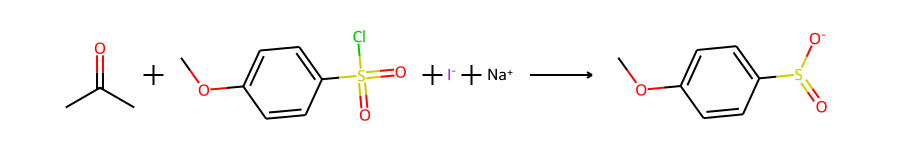

In [70]:
from rdkit.Chem import AllChem, Draw

def visualize_chemical_reaction(reaction_smarts: str):
    # Create a RDKit reaction object from reaction SMARTS string
    reaction = AllChem.ReactionFromSmarts(reaction_smarts, useSmiles=True)
    # Display images
    display(reaction)
    
rxn_example = f'{val_df.iloc[0,0]}>>{val_df.iloc[0,1]}'

visualize_chemical_reaction(rxn_example)

# KEGG data set

In [9]:
kegg_df = pd.read_csv('../data/compounds_final.csv', index_col=0)
kegg_df = kegg_df[['Entry','Names', 'Formula', 'SMILES']]
kegg_df.head()

,Entry,Names,Formula,SMILES
0,C00001,"[""H2O"", ""Water""]",H2O,O
1,C00002,"[""ATP"", ""Adenosine 5'-triphosphate""]",C10H16N5O13P3,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O...
2,C00003,"[""NAD+"", ""NAD"", ""Nicotinamide adenine dinucleo...",C21H28N7O14P2,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...
3,C00004,"[""NADH"", ""DPNH"", ""Reduced nicotinamide adenine...",C21H29N7O14P2,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...
4,C00005,"[""NADPH"", ""TPNH"", ""Reduced nicotinamide adenin...",C21H30N7O17P3,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...


In [82]:
import pubchempy as pcp

def smiles_to_formula(smiles):
    compounds = pcp.get_compounds(smiles, namespace='smiles')
    match = compounds[0]
    return match.molecular_formula

def predict_reaction(precursors):
    """ predict product of one reaction from its precursors SMILES list
    """
    smi_pres = '.'.join(precursors)
    smi_pres = smiles_tokenizer(smi_pres)

    with open('precursors-try.txt', 'w') as f:
        f.write(f'{smi_pres}\n')

    os.system("rm preds.txt")
    os.system("onmt_translate -model models/USPTO480k_model_step_400000.pt -gpu 0 \
               --src precursors-try.txt --output preds.txt \
               --n_best 1 --beam_size 5 --max_length 300 --batch_size 128")

    with open('preds.txt', 'r') as f:
        pred_smi = f.readline().strip()
        pred_smi = pred_smi.replace(" ", "")

    # print result
    print(f"The SMILES of the predicted product is: {pred_smi}")
    print(f"The chemical formula of the predicted product is: {smiles_to_formula(pred_smi)}")
    print("Product:")
    product_mol = Chem.MolFromSmiles(pred_smi)
    display(product_mol)

    return pred_smi


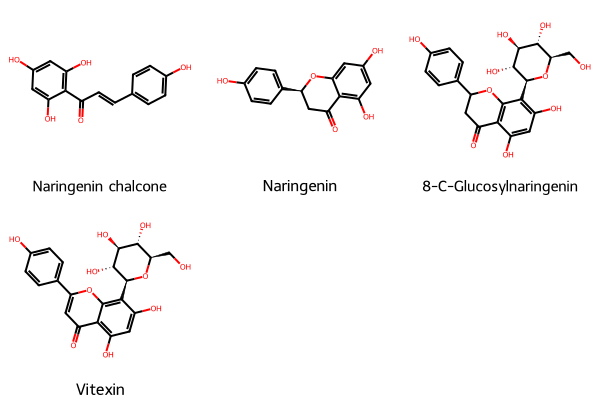

In [21]:
pathway = ['C06561', 'C00509', 'C16492', 'C01460']

names = []
smiles_list = []
for p in pathway:
    names.append(eval(kegg_df[kegg_df['Entry']==p]['Names'].values[0])[0])
    smiles_list.append((kegg_df[kegg_df['Entry']==p]['SMILES'].values[0]))

mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

#Now we create the GridImage
grid = Draw.MolsToGridImage(mols, legends=names) #pass the 'mols' list here and create the image
grid

In [25]:
smiles_list = [canonicalize_smiles(smiles) for smiles in smiles_list]
smiles_list = [smiles_tokenizer(smiles) for smiles in smiles_list]
smiles_list

['O = C ( / C = C / c 1 c c c ( O ) c c 1 ) c 1 c ( O ) c c ( O ) c c 1 O',
 'O = C 1 C [C@@H] ( c 2 c c c ( O ) c c 2 ) O c 2 c c ( O ) c c ( O ) c 2 1',
 'O = C 1 C C ( c 2 c c c ( O ) c c 2 ) O c 2 c 1 c ( O ) c c ( O ) c 2 [C@@H] 1 O [C@H] ( C O ) [C@@H] ( O ) [C@H] ( O ) [C@H] 1 O',
 'O = c 1 c c ( - c 2 c c c ( O ) c c 2 ) o c 2 c ( [C@@H] 3 O [C@H] ( C O ) [C@@H] ( O ) [C@H] ( O ) [C@H] 3 O ) c ( O ) c c ( O ) c 1 2']

Real SMILES of product: CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)C1=CCCCC1
Real formula of product: C28H44N7O17P3S


[2023-06-28 16:17:49,156 INFO] Translating shard 0.
[2023-06-28 16:17:50,021 INFO] PRED AVG SCORE: -0.0264, PRED PPL: 1.0267


The SMILES of the predicted product is: CC(C)(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)OC(=O)C1CCCCC1
The chemical formula of the predicted product is: None
Product:


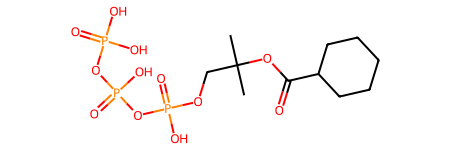

In [85]:
path = ['C09822', 'C09823', 'C09811']

smis = []
for c in path:
    smiles = kegg_df[kegg_df['Entry']==c]['SMILES'].values[0]
    smiles = canonicalize_smiles(smiles)
    smis.append(smiles)

print('Real SMILES of product:', smis[-1])
print('Real formula of product:', kegg_df[kegg_df['Entry'] == path[-1]]['Formula'].values[0])
precursors_smis = smis[:-1]

pred_smi = predict_reaction(precursors_smis)

In [54]:
kegg_df[kegg_df['Formula'] == 'C15H12O5']

,Entry,Names,Formula,SMILES
418,C00509,"[""Naringenin"", ""4',5,7-Trihydroxyflavanone"", ""...",C15H12O5,O=C1C[C@@H](c2ccc(O)cc2)Oc2cc(O)cc(O)c21
968,C01263,"[""3,6,9-Trihydroxypterocarpan"", ""(6aS,11aS)-3,...",C15H12O5,Oc1ccc2c(c1)OC[C@@]1(O)c3ccc(O)cc3O[C@@H]21
1128,C01592,"[""Licodione"", ""1-(2,4-Dihydroxyphenyl)-3-(4-hy...",C15H12O5,O=C(CC(=O)c1ccc(O)cc1O)c1ccc(O)cc1
2104,C03567,"[""2'-Hydroxydihydrodaidzein"", ""2'-Hydroxy-2,3-...",C15H12O5,O=C1c2ccc(O)cc2OCC1c1ccc(O)cc1O
3766,C06561,"[""Naringenin chalcone"", ""2',4,4',6'-Tetrahydro...",C15H12O5,O=C(/C=C/c1ccc(O)cc1)c1c(O)cc(O)cc1O
4142,C08578,"[""Butein""]",C15H12O5,O=C(/C=C/c1ccc(O)c(O)c1)c1ccc(O)cc1O
4239,C09614,"[""Butin"", ""(-)-Butin"", ""7,3',4'-Trihydroxyflav...",C15H12O5,O=C1C[C@@H](c2ccc(O)c(O)c2)Oc2cc(O)ccc21
4262,C09751,"[""Garbanzol"", ""3,7,4'-Trihydroxyflavanone""]",C15H12O5,O=C1c2ccc(O)cc2O[C@H](c2ccc(O)cc2)[C@H]1O
4290,C09826,"[""Pinobanksin"", ""3,5,7-Trihydroxyflavanone""]",C15H12O5,O=C1c2c(O)cc(O)cc2O[C@H](c2ccccc2)[C@H]1O
5304,C15567,"[""2,7,4'-Trihydroxyisoflavanone"", ""2,4',7-Trih...",C15H12O5,O=C1c2ccc(O)cc2OC(O)C1c1ccc(O)cc1
